In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Import the numpy library to work with and manipulate the data
import numpy as np



In [30]:
import urllib.request as urllib2

import pandas as pd
 
#importing dataset in program
url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
response = urllib2.urlopen(url)

dataset = pd.read_csv(response)

dataset = dataset.dropna()
dataset.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd56a623a20>,
      dtype=object)

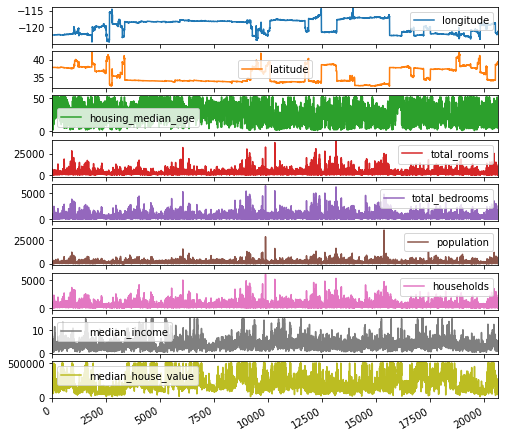

In [31]:
dataset.plot(subplots=True, figsize=(8,8))

In [0]:
Y = dataset['median_house_value']

X = dataset.loc[:,'longitude':'median_income']

# Splits the dataset so 70% is used for training and 30% for testing and a random state is specify
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=2003)
# Converts the datasets to numpy arrays to work with our PyTorch model
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
# Convert the testing data to numpy arrays to work
x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()

In [0]:
#importing the necessary imports from torch library
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn import Dropout
from torch.nn.functional import relu
from torch.utils.data import DataLoader, TensorDataset

In [0]:
# a sub-class is defined 
class CnnRegressor(torch.nn.Module):
  def __init__(self, batch_size, inputs, outputs):
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    # Define the input layer
    self.input_layer = Conv1d(inputs, batch_size, 1)
    #self.dropout = Dropout(0.8)
    # Define a max pooling layer
    self.max_pooling_layer = MaxPool1d(1)
    # Define another convolution layer
    self.conv_layer = Conv1d(batch_size, 256, 1)
      # Define a flatten layer
    self.flatten_layer = Flatten()
    # Define a linear layer
    self.linear_layer = Linear(256, 64)
    # define the output layer
    self.output_layer = Linear(64, outputs)

    # method is defined to give through the model
  def feed(self, input):
    input = input.reshape((self.batch_size, self.inputs, 1))
    output = relu(self.input_layer(input))
    #output = self.dropout(output)
    output = self.max_pooling_layer(output)
    output = relu(self.conv_layer(output))
    output = self.flatten_layer(output)
    output = self.linear_layer(output)
    output = self.output_layer(output)
    return output

In [35]:
from torch.optim import SGD
from torch.optim import Adam,Rprop
from torch.optim import Adadelta
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

# defining a batch size
batch_size = 64
model = CnnRegressor(batch_size, X.shape[1], 1)

# transferring the model to GPU from CPU
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 256, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=256, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
# An average loss and r2 score is evvaluated
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
    predictions = model.feed(input)
    loss = performance(predictions, output)
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_score += score
    count += 1
  return avg_loss / count, avg_score / count

In [37]:
epochs = 500
#defining an optimizer

#optimizer= Adadelta(model.parameters(), lr=1.0, rho=0.4, eps=1e-06, weight_decay=0)
optimizer = Adam(model.parameters())
#optimizer = rprop(model.parameters())
#optimizer = SGD(model.parameters(), lr=1e-5)

# Convert the training set into torch variables for our model using the GPU
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0], 1)).cuda().float()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
# training loop started
xx = 0
yy = 0
for epoch in range(epochs):
# Cycle through the batches and get the average loss
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)
  if avg_r2_score > xx:
    xx = avg_r2_score
    yy = epochs 
# Output the average loss
print("Epoch " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))

Epoch 500:
	Loss = 42574.584781390135
	R^2 Score = 0.7248701242472086


In [38]:
# Convert the testing set into torch variables for our model using the GPU
inputs = torch.from_numpy(x_test_np).cuda().float()
outputs = torch.from_numpy(y_test_np.reshape(y_test_np.shape[0], 1)).cuda().float()

import time
start_time = time.time()
tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)
print("--- %s seconds ---" % (time.time() - start_time))

avg_loss, avg_r2_score = model_loss(model, loader)
print("The model's L1 loss is: " + str(avg_loss))
print("The model's R^2 score is: " + str(avg_r2_score))

--- 0.00022101402282714844 seconds ---
The model's L1 loss is: 45312.326398026315
The model's R^2 score is: 0.6720300691107091
